# Model Based Machine Learning - Used Cars Price Prediction

## Imports

In [1]:
# Uncomment the next line and run the cell to install Pyro for Jupyter Notebook:
#!pip install pyro-ppl

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyro
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
%matplotlib inline


In [3]:
"""Command to create a python file of the notebook (change path as needed):"""""
#c:\Users\cahar\AppData\Local\Programs\Python\Python312\python.exe -m jupyter nbconvert --to script model_based_ml_project.ipynb

'Command to create a python file of the notebook (change path as needed):'

# Data: Description, Preprocessing, and Analysis

In [4]:
# Loading the data and inspect the first rows
df = pd.read_csv('car_price_prediction.csv')
df.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


In [5]:
# Inspect the dataset: we start with the shape of the dataset, columns, and types
print("Dataset shape: ", df.shape)
print("Columns and Types:")
print(df.dtypes)

Dataset shape:  (19237, 18)
Columns and Types:
ID                    int64
Price                 int64
Levy                 object
Manufacturer         object
Model                object
Prod. year            int64
Category             object
Leather interior     object
Fuel type            object
Engine volume        object
Mileage              object
Cylinders           float64
Gear box type        object
Drive wheels         object
Doors                object
Wheel                object
Color                object
Airbags               int64
dtype: object


In [6]:
#check for duplications
df.duplicated().sum()

np.int64(313)

In [7]:
# we will drop duplications and check for missing values
df.drop_duplicates(inplace= True)
df.isnull().sum()

ID                  0
Price               0
Levy                0
Manufacturer        0
Model               0
Prod. year          0
Category            0
Leather interior    0
Fuel type           0
Engine volume       0
Mileage             0
Cylinders           0
Gear box type       0
Drive wheels        0
Doors               0
Wheel               0
Color               0
Airbags             0
dtype: int64

Test relation Nb doors and airbags

Corrélation entre le nombre de portes et le nombre d'airbags : -0.03


C:\Users\33651\AppData\Local\Temp\ipykernel_24688\1266653962.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test['Doors'] = df_test['Doors'].replace({


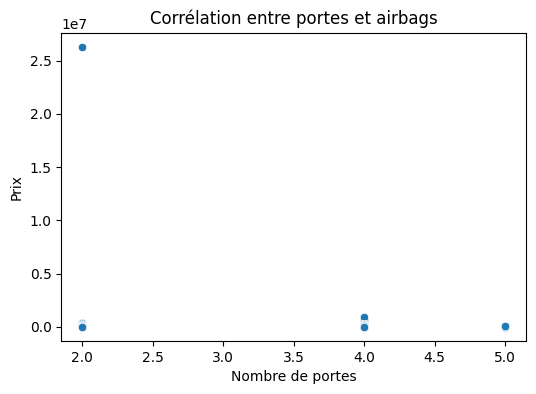

In [8]:
df_test = df.copy()
df_test['Doors'] = df_test['Doors'].replace({
    '>5': 5,
    '02-Mar': 2,
    '04-May': 4
})
df_test['Doors'] = pd.to_numeric(df_test['Doors'], errors='coerce').astype('Int64')


df_corr = df_test[['Doors', 'Price']].dropna()

# Calcul de la corrélation de Pearson
correlation = df_corr['Doors'].corr(df_corr['Price'])

print(f"Corrélation entre le nombre de portes et le nombre d'airbags : {correlation:.2f}")

plt.figure(figsize=(6, 4))
sns.scatterplot(data=df_corr, x='Doors', y='Price')
plt.title('Corrélation entre portes et airbags')
plt.xlabel('Nombre de portes')
plt.ylabel('Prix')
plt.show()


       Doors     Price
16983      2  26307500
5008       2    308906
9367       2    297930
2283       2    219527
17868      2    150533
...      ...       ...
1938       2        78
15734      2        60
15675      2        50
7359       2         6
5890       2         3

[768 rows x 2 columns]


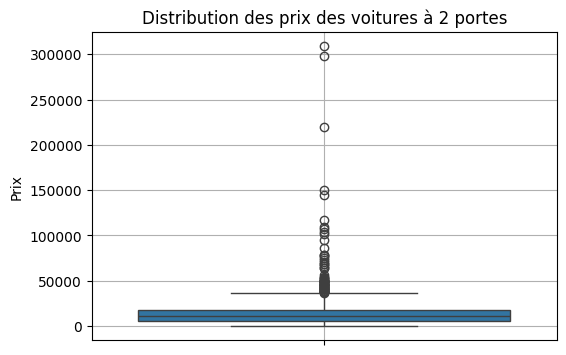

In [9]:
df_doors_2 =df_corr[df_corr['Doors'] == 2].sort_values(by='Price', ascending=False)
print(df_doors_2)
df_doors_2.drop(index=16983, inplace=True)  # Suppression de la ligne avec l'index 16983
plt.figure(figsize=(6, 4))
sns.boxplot(data=df_doors_2, y='Price')
plt.title('Distribution des prix des voitures à 2 portes')
plt.ylabel('Prix')
plt.grid(True)
plt.show()



Test 2 : Category nb price et nb doors

C:\Users\33651\AppData\Local\Temp\ipykernel_24688\2684367398.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test2['Doors'] = df_test2['Doors'].replace({


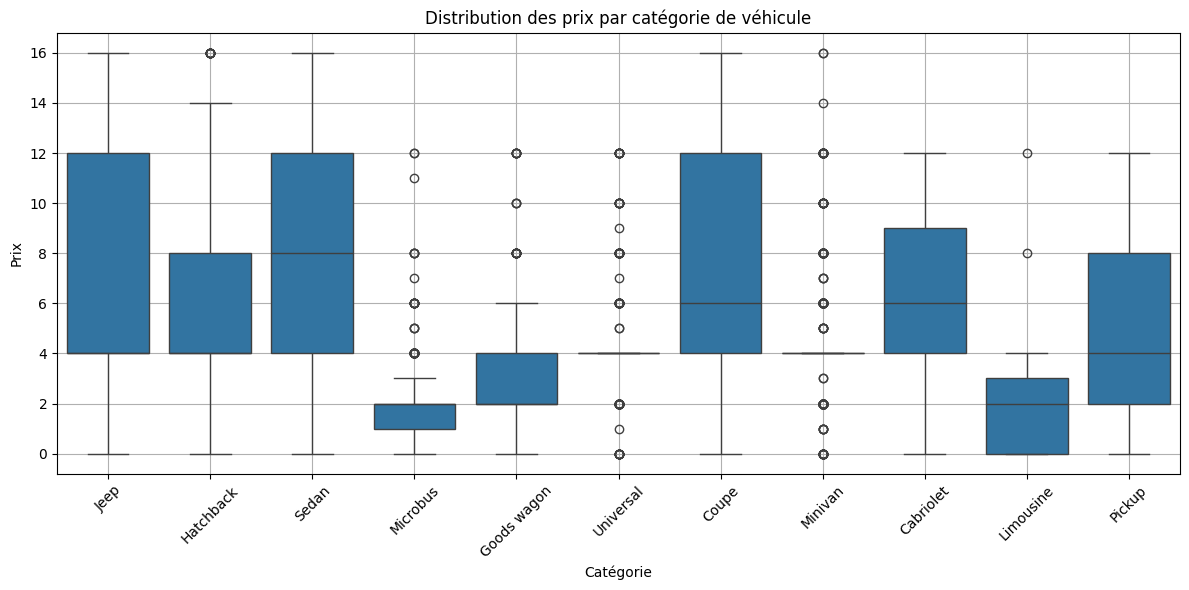

In [10]:
df_test2 = df.copy()
df_test2['Doors'] = df_test2['Doors'].replace({
    '>5': 5,
    '02-Mar': 2,
    '04-May': 4
})
df_test2['Doors'] = pd.to_numeric(df_test['Doors'], errors='coerce').astype('Int64')

df_test2.groupby('Category')['Airbags'].mean().sort_values(ascending=False)
df_test2 = df_test2[df_test2['Price']<100000]
plt.figure(figsize=(12, 6))  # ajuste la taille selon le nombre de catégories

sns.boxplot(data=df_test2, x='Category', y='Airbags')
plt.title("Distribution des prix par catégorie de véhicule")
plt.xlabel("Catégorie")
plt.ylabel("Prix")
plt.xticks(rotation=45)  # rotation pour lisibilité
plt.grid(True)
plt.tight_layout()
plt.show()

Does airbags have an impact on car categories ?

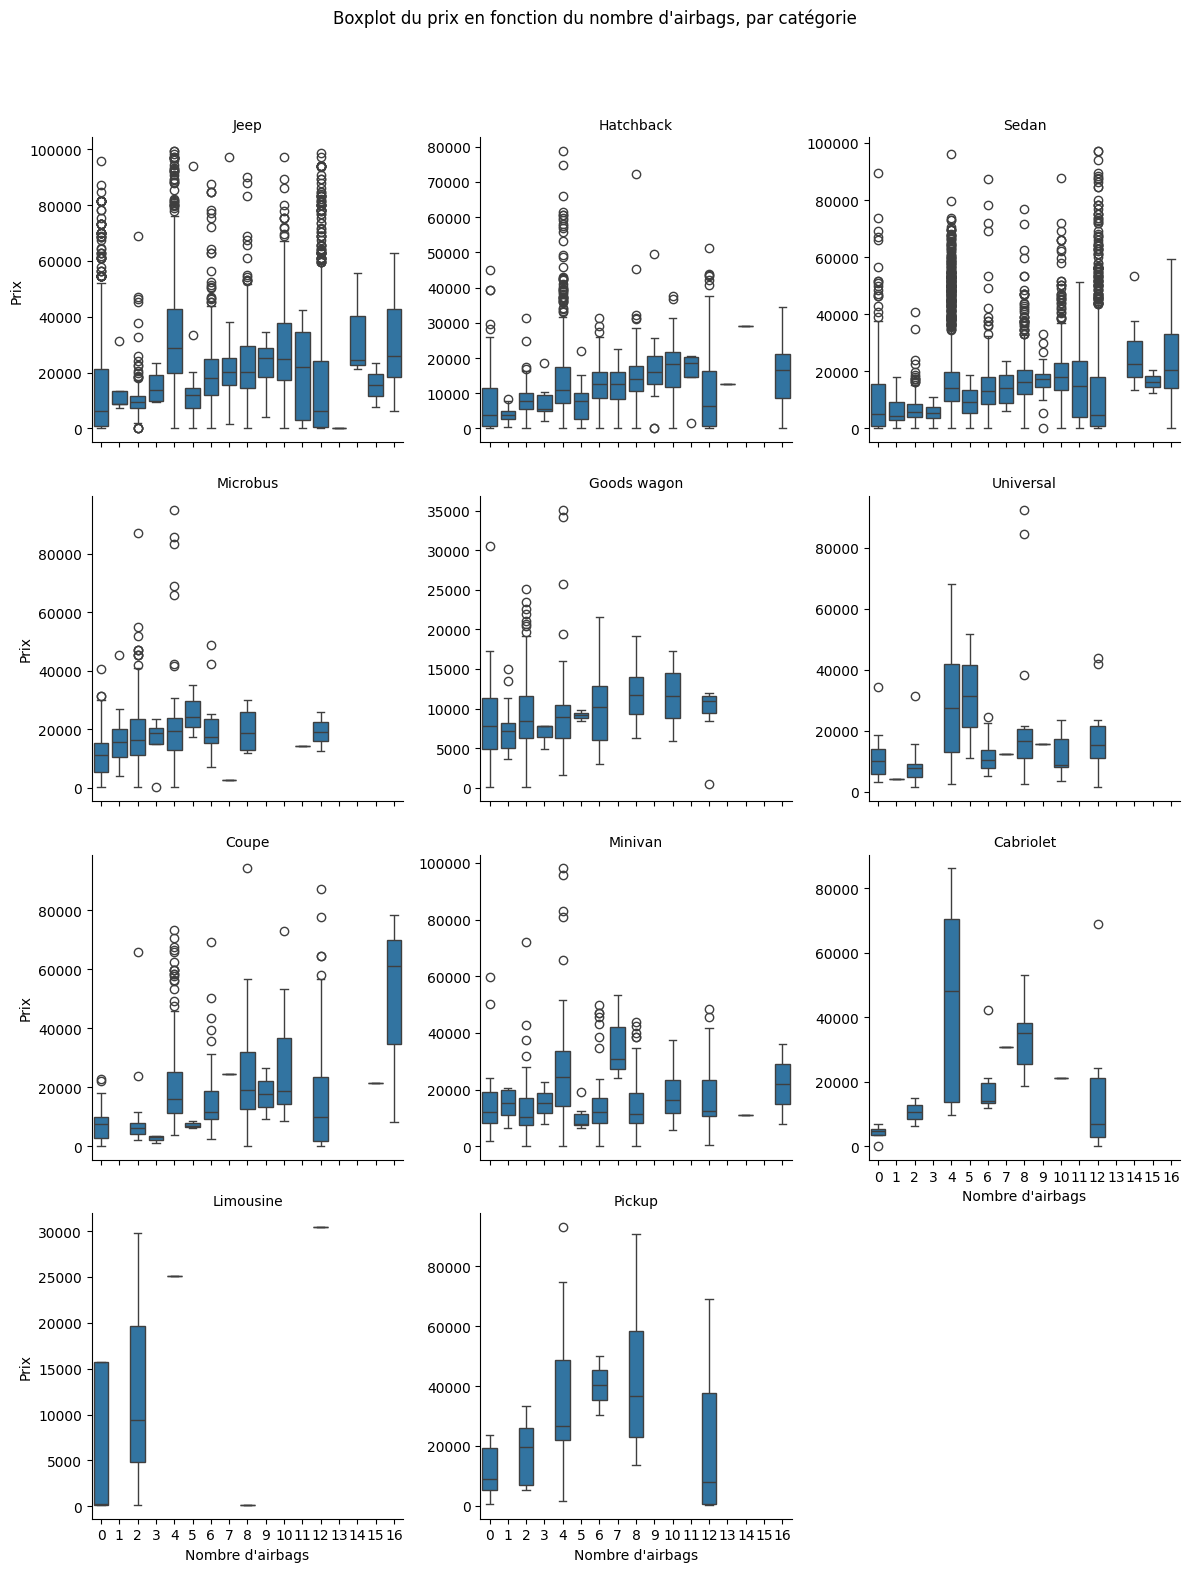

In [11]:
df_box = df_test2[['Category', 'Airbags', 'Price']].dropna()

# Convertir Airbags en type int (si nécessaire)
df_box['Airbags'] = df_box['Airbags'].astype(int)

# Créer un boxplot par catégorie
g = sns.FacetGrid(df_box, col="Category", col_wrap=3, height=4, sharey=False)
g.map_dataframe(sns.boxplot, x="Airbags", y="Price")
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Nombre d'airbags", "Prix")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Boxplot du prix en fonction du nombre d'airbags, par catégorie")
plt.show()

Preprocessing

As expected, there are many values that need preprocessing, and we can also ignore some features that we believe that do not have influence over the price (e.g. Steering wheels side, color and ID). Other features need to be treated differently: for example, milage contains the string "KM", this should be removed and the values should contain only the numerical value. Other features such as engine volume, contain some additional information about the engine like "turbo" - which we will split into another binary feature that will contain values 0 or 1 for whether the engine is a turbo engine (0 if not, else 1). Additionally, many of the features are categorical, hence we will use one-hot encoding or ordinal encoding to fix them and fit them to a regression model.

Another desicion is to drop the attribute "model". This is due to high cardinality, as we have 1590 unique values (see the list below). Moreover, the "model" feature can be captured by other features of the car. i.e. the common sense is saying that the model is a major factor in the price, however, we believe that the rest of the features will capture the quality of a certain model (e.g. engine volume, leather seats, number of airbags etc). 

In [12]:
# Drop irrelevant columns -4 columns
df_cleaned = df.drop(columns=['ID', 'Model', 'Color', 'Wheel','Doors'])

# Levy to numeric
df_cleaned['Levy'] = df_cleaned['Levy'].replace('-', pd.NA)
df_cleaned['Levy'] = pd.to_numeric(df_cleaned['Levy'], errors='coerce')

#Leather interior to binary
df_cleaned['Leather interior'] = df_cleaned['Leather interior'].map({'Yes': 1, 'No': 0})

In [13]:
#check the unique values and additional strings in engine volume
engine_volume_values = df_cleaned['Engine volume'].unique()
sorted(engine_volume_values)

['0',
 '0.1',
 '0.2',
 '0.2 Turbo',
 '0.3',
 '0.3 Turbo',
 '0.4',
 '0.4 Turbo',
 '0.5',
 '0.6',
 '0.6 Turbo',
 '0.7',
 '0.7 Turbo',
 '0.8',
 '0.8 Turbo',
 '0.9',
 '1',
 '1.0 Turbo',
 '1.1',
 '1.1 Turbo',
 '1.2',
 '1.2 Turbo',
 '1.3',
 '1.3 Turbo',
 '1.4',
 '1.4 Turbo',
 '1.5',
 '1.5 Turbo',
 '1.6',
 '1.6 Turbo',
 '1.7',
 '1.7 Turbo',
 '1.8',
 '1.8 Turbo',
 '1.9',
 '1.9 Turbo',
 '2',
 '2.0 Turbo',
 '2.1',
 '2.1 Turbo',
 '2.2',
 '2.2 Turbo',
 '2.3',
 '2.3 Turbo',
 '2.4',
 '2.4 Turbo',
 '2.5',
 '2.5 Turbo',
 '2.6',
 '2.7',
 '2.7 Turbo',
 '2.8',
 '2.8 Turbo',
 '2.9',
 '2.9 Turbo',
 '20',
 '3',
 '3.0 Turbo',
 '3.1',
 '3.2',
 '3.2 Turbo',
 '3.3',
 '3.4',
 '3.5',
 '3.5 Turbo',
 '3.6',
 '3.6 Turbo',
 '3.7',
 '3.7 Turbo',
 '3.8',
 '3.9',
 '4',
 '4.0 Turbo',
 '4.2',
 '4.2 Turbo',
 '4.3',
 '4.4',
 '4.4 Turbo',
 '4.5',
 '4.5 Turbo',
 '4.6',
 '4.6 Turbo',
 '4.7',
 '4.7 Turbo',
 '4.8',
 '4.8 Turbo',
 '5',
 '5.0 Turbo',
 '5.2',
 '5.3',
 '5.4',
 '5.4 Turbo',
 '5.5',
 '5.5 Turbo',
 '5.6',
 '5.7',
 '5.7

In [14]:
# Create 'Turbo' binary column
df_cleaned['Turbo'] = df_cleaned['Engine volume'].str.contains('Turbo').astype(int)

# Extract numeric part of engine volume
df_cleaned['Engine volume'] = df_cleaned['Engine volume'].str.replace(' Turbo', '', regex=False).astype(float)

In [15]:
#Drop 'Fuel type'
df_cleaned = df_cleaned.drop(columns=['Fuel type'])

# Mileage - remove ' km' and convert to numeric
df_cleaned['Mileage'] = df_cleaned['Mileage'].str.replace(' km', '', regex=False).str.replace(',', '')
df_cleaned['Mileage'] = pd.to_numeric(df_cleaned['Mileage'], errors='coerce')

# Cylinders and Airbags - numeric
df_cleaned['Cylinders'] = pd.to_numeric(df_cleaned['Cylinders'], errors='coerce')
df_cleaned['Airbags'] = pd.to_numeric(df_cleaned['Airbags'], errors='coerce')

# Preprocessing production year to Age
current_year = datetime.now().year
df_cleaned['Age'] = current_year - df_cleaned['Prod. year']
df_cleaned = df_cleaned.drop(columns=['Prod. year'])

# Preview the cleaned dataframe
df_cleaned.head()
print(df_cleaned.columns)


Index(['Price', 'Levy', 'Manufacturer', 'Category', 'Leather interior',
       'Engine volume', 'Mileage', 'Cylinders', 'Gear box type',
       'Drive wheels', 'Airbags', 'Turbo', 'Age'],
      dtype='object')


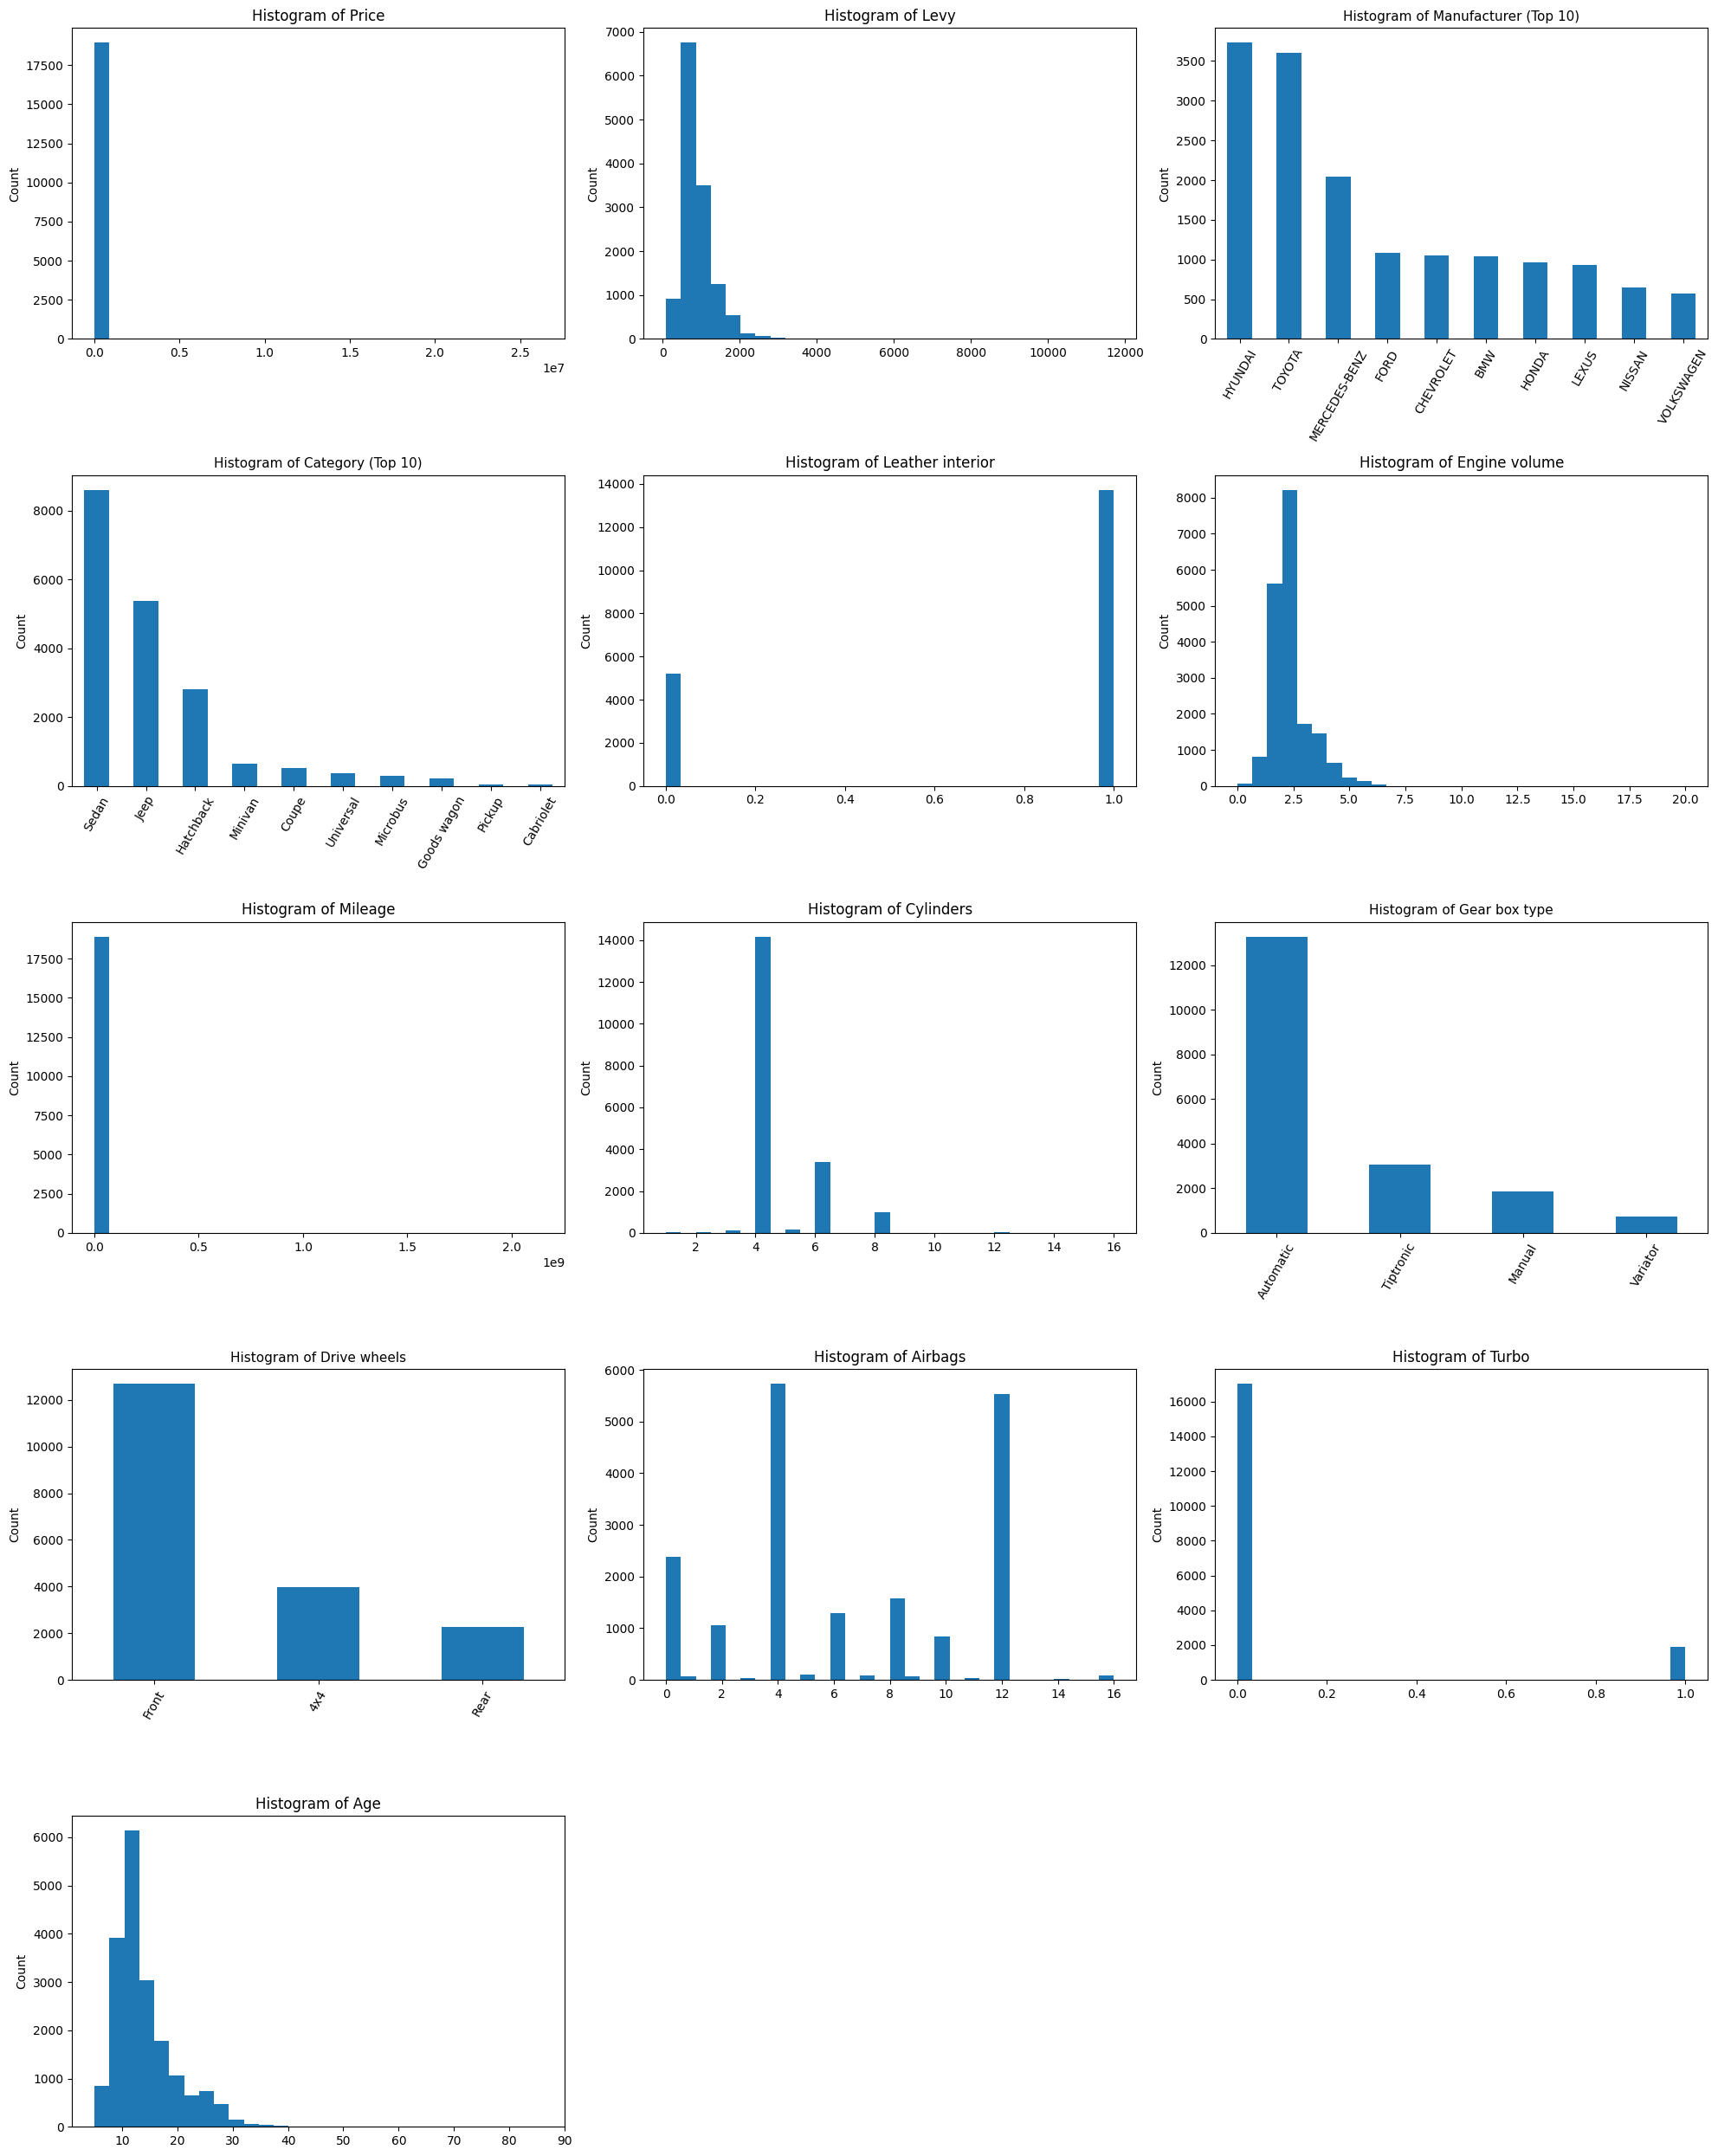

In [16]:

# Number of columns per row in the plot grid
n_cols = 3
n_rows = -(-len(df_cleaned.columns) // n_cols)  # Ceiling division

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))
axes = axes.flatten()

# Plot each feature
for i, col in enumerate(df_cleaned.columns):
    ax = axes[i]
    try:
        # If the column can be converted to numeric, use histogram
        df_cleaned[col].astype(float)
        df_cleaned[col].astype(float).plot(kind='hist', bins=30, ax=ax)
        ax.set_title(f"Histogram of {col}")
    except:
        # For categorical data, show only the top 20 most frequent categories
        vc = df[col].value_counts(dropna=False)
        vc[:10].plot(kind='bar', ax=ax)
        ax.set_title(f"Histogram of {col} (Top 10)" if df_cleaned.nunique()[col]>=10 else f"Histogram of {col}" , fontsize=11)
        ax.tick_params(axis='x', rotation=60)
    ax.set_xlabel('')
    ax.set_ylabel('Count')

# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [17]:
print("Descriptive Statistics:")
df_cleaned.describe().T

Descriptive Statistics:


,count,mean,std,min,25%,50%,75%,max
Price,18924.0,1.858744e+04,1.921356e+05,1.0,5331.00,13172.0,22063.00,2.630750e+07
Levy,13215.0,9.062992e+02,4.632969e+02,87.0,640.00,781.0,1058.00,1.171400e+04
Leather interior,18924.0,7.255866e-01,4.462300e-01,0.0,0.00,1.0,1.00,1.000000e+00
Engine volume,18924.0,2.306251e+00,8.775910e-01,0.0,1.80,2.0,2.50,2.000000e+01
Mileage,18924.0,1.555373e+06,4.880221e+07,0.0,70195.75,126400.0,189119.75,2.147484e+09
Cylinders,18924.0,4.580216e+00,1.200223e+00,1.0,4.00,4.0,4.00,1.600000e+01
Airbags,18924.0,6.568379e+00,4.322323e+00,0.0,4.00,6.0,12.00,1.600000e+01
Turbo,18924.0,9.997886e-02,2.999797e-01,0.0,0.00,0.0,0.00,1.000000e+00
Age,18924.0,1.408576e+01,5.665749e+00,5.0,10.00,13.0,16.00,8.600000e+01


In [18]:
df_columns_numerical=df_cleaned.select_dtypes(include=[np.number])
df_columns_numerical.corr()  # Exclude target variable


,Price,Levy,Leather interior,Engine volume,Mileage,Cylinders,Airbags,Turbo,Age
Price,1.000000,0.065458,0.000551,0.008888,-0.001763,0.007435,-0.012709,0.016973,-0.012689
Levy,0.065458,1.000000,0.016867,0.647074,0.023746,0.587886,0.078621,-0.021869,0.239338
Leather interior,0.000551,0.016867,1.000000,0.271749,-0.034682,0.199716,0.161889,-0.104543,-0.388608
Engine volume,0.008888,0.647074,0.271749,1.000000,-0.006292,0.777228,0.221991,-0.017630,0.032427
Mileage,-0.001763,0.023746,-0.034682,-0.006292,1.000000,-0.001720,-0.009174,-0.001490,0.064058
Cylinders,0.007435,0.587886,0.199716,0.777228,-0.001720,1.000000,0.174112,0.035407,0.099443
Airbags,-0.012709,0.078621,0.161889,0.221991,-0.009174,0.174112,1.000000,0.062424,-0.235160
Turbo,0.016973,-0.021869,-0.104543,-0.017630,-0.001490,0.035407,0.062424,1.000000,0.077724
Age,-0.012689,0.239338,-0.388608,0.032427,0.064058,0.099443,-0.235160,0.077724,1.000000


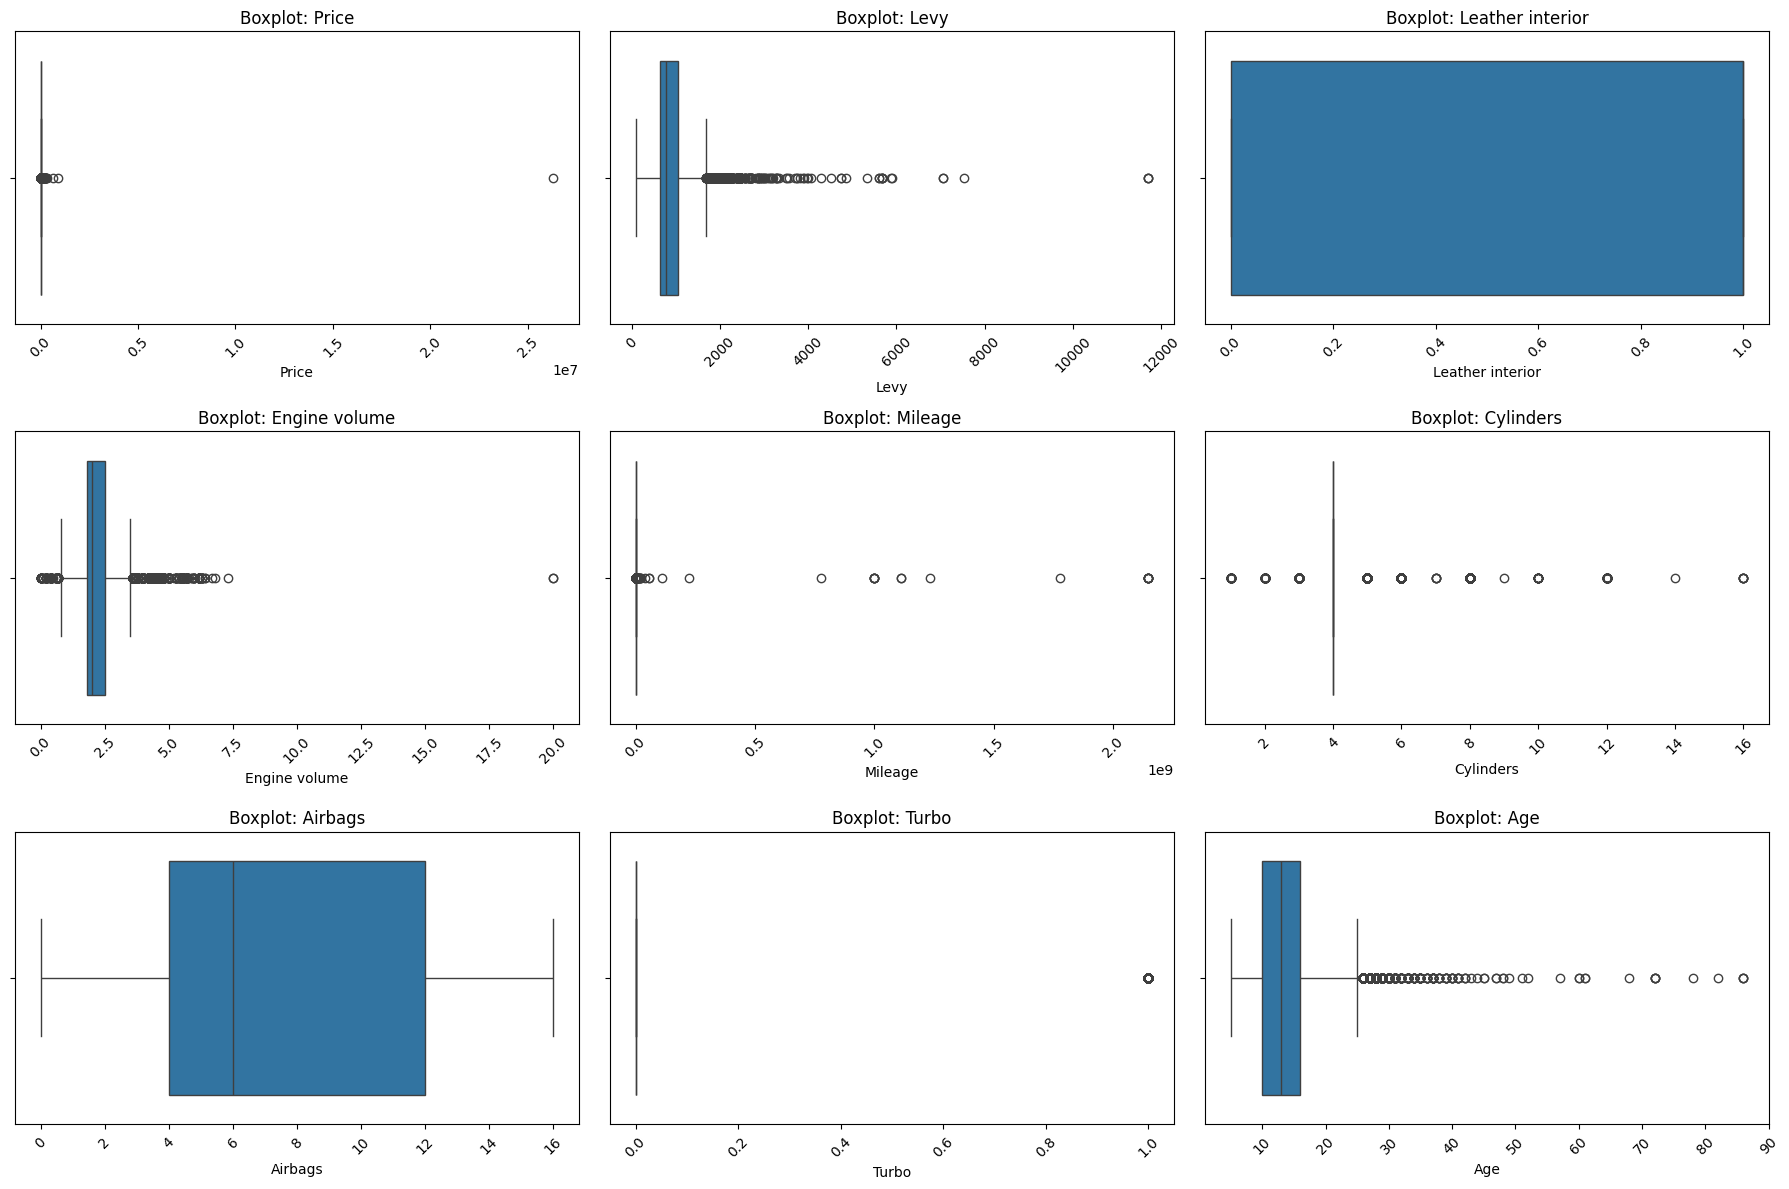

In [19]:
# Select only numerical columns
numeric_cols = df_cleaned.select_dtypes(include=['float64', 'int64']).columns

# Set up plot
n_cols = 3
n_rows = -(-len(numeric_cols) // n_cols)  # Ceiling division
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
axes = axes.flatten()

# Create boxplot for each numeric feature
for i, col in enumerate(numeric_cols):
    sns.boxplot(data=df_cleaned, x=col, ax=axes[i])
    axes[i].set_title(f'Boxplot: {col}')
    axes[i].tick_params(axis='x', rotation=45)

# Hide any empty subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
fig.savefig('boxplots.png', bbox_inches='tight')
plt.show()

In [20]:
print(f"Number of entries: {len(df_cleaned[df_cleaned['Price'] > 50000])}")

Number of entries: 908


In [21]:
print(f"Number of entries: {len(df_cleaned[df_cleaned['Price'] < 2000])}")

Number of entries: 3141


There are 908 records of cars that their price is greater than 50,000. Also, 3,141 cars that are priced under 2,000. We will drop them, and plot the price distribution again:

In [22]:
df_cleaned = df_cleaned[(df_cleaned['Price'] >= 2000) & (df_cleaned['Price'] <= 50000)]

Due to heavy skewness of the prices, we will try to plot the distribution in it's log-values. It might help us later in the baseline model, to improve linearity between the predicted variable and the predictors.

In [23]:
# we will create a list of averages by manufacturer
manufacturer_avg_price = df_cleaned.groupby('Manufacturer')['Price'].mean()

# we will create the bins, then we assing them to the manufacturer average list:
bins = [2000, 10000, 15000, 20000, 25000, 32000, float('inf')]
labels = [1, 2, 3, 4, 5, 6]

manufacturer_price_bins = pd.cut(manufacturer_avg_price, bins=bins, labels=labels)
manufacturer_price_bins

Manufacturer
ACURA            1
ALFA ROMEO       1
AUDI             3
BMW              3
BUICK            2
CADILLAC         3
CHEVROLET        3
CHRYSLER         2
CITROEN          2
DAEWOO           1
DAIHATSU         1
DODGE            2
FERRARI          5
FIAT             2
FORD             3
GAZ              1
GMC              1
GREATWALL        2
HAVAL            3
HONDA            2
HUMMER           5
HYUNDAI          4
INFINITI         3
ISUZU            1
JAGUAR           4
JEEP             4
KIA              3
LANCIA           2
LAND ROVER       3
LEXUS            4
LINCOLN          3
MASERATI         5
MAZDA            2
MERCEDES-BENZ    3
MERCURY          3
MINI             3
MITSUBISHI       2
MOSKVICH         3
NISSAN           2
OPEL             1
PEUGEOT          1
PONTIAC          1
PORSCHE          4
RENAULT          2
ROVER            1
SAAB             1
SATURN           2
SCION            3
SEAT             1
SKODA            3
SSANGYONG        5
SUBARU           2

In [24]:
# lastly we will map each row by the manufacturer_price_bins list
df_cleaned['Manufacturer_encoded'] = df_cleaned['Manufacturer'].map(manufacturer_price_bins)
df_cleaned['Manufacturer_encoded'] = df_cleaned['Manufacturer_encoded'].astype(int)
df_cleaned.head()

,Price,Levy,Manufacturer,Category,Leather interior,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Airbags,Turbo,Age,Manufacturer_encoded
0,13328,1399.0,LEXUS,Jeep,1,3.5,186005,6.0,Automatic,4x4,12,0,15,4
1,16621,1018.0,CHEVROLET,Jeep,0,3.0,192000,6.0,Tiptronic,4x4,8,0,14,3
2,8467,NaN,HONDA,Hatchback,0,1.3,200000,4.0,Variator,Front,2,0,19,2
3,3607,862.0,FORD,Jeep,1,2.5,168966,4.0,Automatic,4x4,0,0,14,3
4,11726,446.0,HONDA,Hatchback,1,1.3,91901,4.0,Automatic,Front,4,0,11,2


## Bayesian models

First Model PGM

In [25]:
import pandas as pd
from pgmpy.models import BayesianNetwork, DiscreteBayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator
from pgmpy.inference import VariableElimination
import pymc as pm
import torch




INFO:arviz.preview:arviz_base not installed
INFO:arviz.preview:arviz_stats not installed
INFO:arviz.preview:arviz_plots not installed


In [26]:
df_pgm1 = df_cleaned.copy()
df_pgm1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14875 entries, 0 to 19235
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Price                 14875 non-null  int64  
 1   Levy                  9848 non-null   float64
 2   Manufacturer          14875 non-null  object 
 3   Category              14875 non-null  object 
 4   Leather interior      14875 non-null  int64  
 5   Engine volume         14875 non-null  float64
 6   Mileage               14875 non-null  int64  
 7   Cylinders             14875 non-null  float64
 8   Gear box type         14875 non-null  object 
 9   Drive wheels          14875 non-null  object 
 10  Airbags               14875 non-null  int64  
 11  Turbo                 14875 non-null  int64  
 12  Age                   14875 non-null  int64  
 13  Manufacturer_encoded  14875 non-null  int64  
dtypes: float64(3), int64(7), object(4)
memory usage: 1.7+ MB


Data Preparation

In [27]:
from sklearn.preprocessing import StandardScaler

categorical_cols = ['Category', 'Gear box type']  # exemple

X_cat_onehot = pd.get_dummies(df_pgm1[categorical_cols]).astype(int)
X_onehot = pd.concat([df_pgm1, X_cat_onehot], axis=1)


X = X_onehot.drop(columns=['Price','Airbags','Drive wheels', 'Gear box type', 'Category','Manufacturer','Levy',],)
y = df_pgm1['Price']

#Normalisation : Maybe add Age, Cylinders, Engine Volume later
columns_to_scale =['Mileage']
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[columns_to_scale] = scaler.fit_transform(X_scaled[columns_to_scale])
X_scaled.describe()
y_scaled = y/1000

In [28]:
X_scaled.head()


,Leather interior,Engine volume,Mileage,Cylinders,Turbo,Age,Manufacturer_encoded,Category_Cabriolet,Category_Coupe,Category_Goods wagon,...,Category_Limousine,Category_Microbus,Category_Minivan,Category_Pickup,Category_Sedan,Category_Universal,Gear box type_Automatic,Gear box type_Manual,Gear box type_Tiptronic,Gear box type_Variator
0,1,3.5,-0.029818,6.0,0,15,4,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,3.0,-0.029702,6.0,0,14,3,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,1.3,-0.029546,4.0,0,19,2,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,2.5,-0.030150,4.0,0,14,3,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,1,1.3,-0.031651,4.0,0,11,2,0,0,0,...,0,0,0,0,0,0,1,0,0,0


Get train and test set

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2)
X_train = torch.tensor(X_train.values, dtype=torch.float32)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)
print("X_train shape:", y_train.shape)


X_train shape: torch.Size([11900])


Define a model

In [30]:
# Linear Bayesian model y= X.w + bias + sigma

def linear_bayesian_model(X,y=None):
    N, D = X.shape  # N: nombre d'exemples, D: nombre de features
    weight = pyro.sample('weight', pyro.distributions.Normal(torch.zeros(D), torch.ones(D)).to_event(1))
    bias = pyro.sample('bias', pyro.distributions.Normal(0., 1.))
    #sigma = pyro.sample('sigma', pyro.distributions.HalfCauchy(1.0))
    sigma = 2

    mean = torch.matmul(X, weight) + bias
    with pyro.plate('data', N):
        obs = pyro.sample('obs', pyro.distributions.Normal(mean, sigma), obs=y)
    return obs


In [31]:
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal, AutoNormal
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import ClippedAdam

train_elbos = []
test_elbos = []
# Define guide function
#guide = AutoDiagonalNormal(ppca_model)
guide = AutoNormal(linear_bayesian_model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 10000

# Setup the optimizer
adam_params = {"lr": 0.001}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=3)
svi = SVI(linear_bayesian_model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train, y_train)
    test_loss = svi.evaluate_loss(X_test, y_test)  # évaluation (pas de mise à jour)

    train_elbos.append(elbo)
    test_elbos.append(test_loss)

    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 660867.2
[500] ELBO: 267137.3
[1000] ELBO: 200936.5
[1500] ELBO: 169525.5
[2000] ELBO: 156137.2
[2500] ELBO: 147904.2
[3000] ELBO: 142449.9
[3500] ELBO: 138399.7
[4000] ELBO: 135959.5
[4500] ELBO: 134695.4
[5000] ELBO: 133840.8
[5500] ELBO: 133278.1
[6000] ELBO: 132776.2
[6500] ELBO: 132381.7
[7000] ELBO: 132033.2
[7500] ELBO: 131802.2
[8000] ELBO: 131641.2
[8500] ELBO: 131563.6
[9000] ELBO: 131515.5
[9500] ELBO: 131486.3


Evaluate overfitting

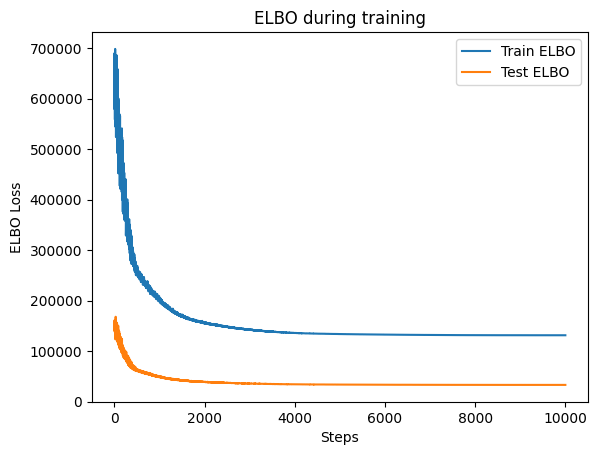

In [32]:

plt.plot(train_elbos, label="Train ELBO")
plt.plot(test_elbos, label="Test ELBO")
plt.xlabel("Steps")
plt.ylabel("ELBO Loss")
plt.legend()
plt.title("ELBO during training")
plt.show()


In [33]:
#X.columns
latent = guide(X_train)  # sample un point dans la distribution approx
weights = latent['weight'].detach().cpu().numpy()

columns = ['Leather interior', 'Engine volume', 'Mileage', 'Cylinders', 'Turbo',
       'Age', 'Manufacturer_encoded', 'Category_Cabriolet', 'Category_Coupe',
       'Category_Goods wagon', 'Category_Hatchback', 'Category_Jeep',
       'Category_Limousine', 'Category_Microbus', 'Category_Minivan',
       'Category_Pickup', 'Category_Sedan', 'Category_Universal',
       'Gear box type_Automatic', 'Gear box type_Manual',
       'Gear box type_Tiptronic', 'Gear box type_Variator']

print("Weight learned for each feature:")
for name, w in zip(columns, weights):
    print(f"{name:20s} : {w:.4f}")

# Optionnel : biais et sigma
print(f"Biais learned : {latent['bias'].item():.4f}")
#print(f"Sigma learned : {latent['sigma'].item():.4f}")


Weight learned for each feature:
Leather interior     : 0.2097
Engine volume        : 0.8567
Mileage              : 0.0316
Cylinders            : 0.2459
Turbo                : 4.2849
Age                  : -0.7981
Manufacturer_encoded : 3.3044
Category_Cabriolet   : 5.8509
Category_Coupe       : 2.6718
Category_Goods wagon : 0.6568
Category_Hatchback   : 1.5122
Category_Jeep        : 7.2335
Category_Limousine   : 8.5013
Category_Microbus    : 4.7782
Category_Minivan     : 7.4499
Category_Pickup      : 7.4103
Category_Sedan       : 0.5208
Category_Universal   : 8.1065
Gear box type_Automatic : 2.3782
Gear box type_Manual : 6.6348
Gear box type_Tiptronic : 7.1528
Gear box type_Variator : 5.2303
Biais learned : 8.3798


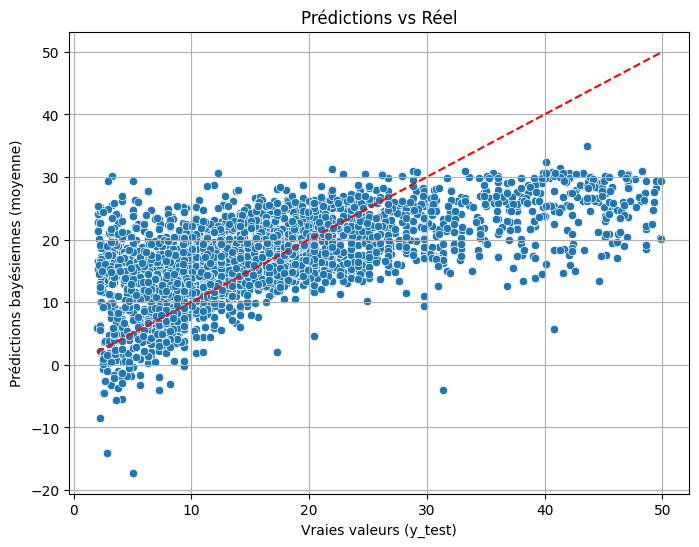

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from pyro.infer import Predictive

predictive = Predictive(linear_bayesian_model, guide=guide, num_samples=1000)
samples = predictive(X_test)

# Moyenne des prédictions (shape: [batch_size])
y_pred_mean = samples["obs"].mean(0)      # moyenne bayésienne
y_pred_std = samples["obs"].std(0)        # incertitude prédictive

# y_test doit être de même type et forme
y_test_np = y_test.detach().numpy()
y_pred_np = y_pred_mean.detach().numpy()
y_std_np = y_pred_std.detach().numpy()

# Scatter plot : prédiction vs vrai
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_np, y=y_pred_np)
plt.plot([y_test_np.min(), y_test_np.max()], [y_test_np.min(), y_test_np.max()], 'r--')  # ligne y=x
plt.xlabel("Vraies valeurs (y_test)")
plt.ylabel("Prédictions bayésiennes (moyenne)")
plt.title("Prédictions vs Réel")
plt.grid(True)
plt.show()


In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test_np, y_pred_np)
rmse = torch.sqrt(torch.tensor(mse))
mae = mean_absolute_error(y_test_np, y_pred_np)
r2 = r2_score(y_test_np, y_pred_np)


print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R²    : {r2:.4f}")
print("Y_std:", y_std_np)
print("Y_pred:", y_pred_np)


MAE  : 6.57
RMSE : 8.67
R²    : 0.3514
Y_std: [1.9119945 2.0202975 2.0010557 ... 1.9320217 2.0587733 1.943105 ]
Y_pred: [13.46647  13.068607 16.640768 ... 21.156681 25.56286  12.499568]


### Model 2

PGM

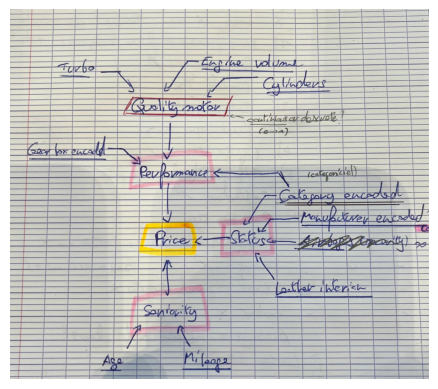

In [45]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('PGM.jpg')
plt.imshow(img)
plt.axis('off')
plt.show()


Data process

In [36]:
X_scaled.columns
columns_quality = ['Turbo', 'Engine volume', 'Cylinders']
columns_seniority = ['Age', 'Mileage']
columns_performance = ['Category_Cabriolet', 'Category_Coupe',
       'Category_Goods wagon', 'Category_Hatchback', 'Category_Jeep',
       'Category_Limousine', 'Category_Microbus', 'Category_Minivan',
       'Category_Pickup', 'Category_Sedan', 'Category_Universal',
       'Gear box type_Automatic', 'Gear box type_Manual',
       'Gear box type_Tiptronic', 'Gear box type_Variator']
columns_status = ['Leather interior', 'Manufacturer_encoded', 'Category_Cabriolet', 'Category_Coupe',
       'Category_Goods wagon', 'Category_Hatchback', 'Category_Jeep',
       'Category_Limousine', 'Category_Microbus', 'Category_Minivan',
       'Category_Pickup', 'Category_Sedan', 'Category_Universal']

In [37]:

X_scaled_model2 =X_scaled.copy()
y_scaled_model2 = y_scaled.copy()
X_train, X_test, y_train, y_test = train_test_split(X_scaled_model2, y_scaled_model2, test_size=0.2)

X_train_quality = X_train[columns_quality]
X_train_seniority = X_train[columns_seniority]
X_train_performance = X_train[columns_performance]
X_train_status = X_train[columns_status]

X_test_quality = X_test[columns_quality]
X_test_seniority = X_test[columns_seniority]
X_test_performance = X_test[columns_performance]
X_test_status = X_test[columns_status]

X_train_quality = torch.tensor(X_train_quality.values, dtype=torch.float32)
X_train_performance = torch.tensor(X_train_performance.values, dtype=torch.float32)
X_train_status = torch.tensor(X_train_status.values, dtype=torch.float32)
X_train_seniority = torch.tensor(X_train_seniority.values, dtype=torch.float32)

X_test_quality = torch.tensor(X_test_quality.values, dtype=torch.float32)
X_test_performance = torch.tensor(X_test_performance.values, dtype=torch.float32)
X_test_status = torch.tensor(X_test_status.values, dtype=torch.float32)
X_test_seniority = torch.tensor(X_test_seniority.values, dtype=torch.float32)

y_train = torch.tensor(y_train.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

In [38]:
import pyro.distributions

#Latent deterministic for now
def model2(X_quality, X_performance, X_status, X_seniority, y=None):
    N = X_quality.shape[0]

    # Quality latent
    D_q = X_quality.shape[1]
    w_q = pyro.sample("w_quality", pyro.distributions.Normal(torch.zeros(D_q), torch.ones(D_q)).to_event(1))
    b_q = pyro.sample("b_quality", pyro.distributions.Normal(0., 1.))
    quality_latent = torch.matmul(X_quality, w_q) + b_q

    # Performance latent conditionné sur quality
    D_p = X_performance.shape[1]
    w_p_x = pyro.sample("w_performance_x", pyro.distributions.Normal(torch.zeros(D_p), torch.ones(D_p)).to_event(1))
    w_p_q = pyro.sample("w_performance_q", pyro.distributions.Normal(0., 1.))  # pondère quality_latent
    b_p = pyro.sample("b_performance", pyro.distributions.Normal(0., 1.))
    performance_latent = torch.matmul(X_performance, w_p_x) + w_p_q * quality_latent + b_p

    # Status
    D_s = X_status.shape[1]
    w_s = pyro.sample("w_status", pyro.distributions.Normal(torch.zeros(D_s), torch.ones(D_s)).to_event(1))
    b_s = pyro.sample("b_status", pyro.distributions.Normal(0., 1.))
    status_latent = torch.matmul(X_status, w_s) + b_s

    # Seniority
    D_se = X_seniority.shape[1]
    w_se = pyro.sample("w_seniority", pyro.distributions.Normal(torch.zeros(D_se), torch.ones(D_se)).to_event(1))
    b_se = pyro.sample("b_seniority", pyro.distributions.Normal(0., 1.))
    seniority_latent = torch.matmul(X_seniority, w_se) + b_se

    # Global linear combination
    w_perf = pyro.sample("w_perf", pyro.distributions.Normal(0., 1.))
    w_stat = pyro.sample("w_stat", pyro.distributions.Normal(0., 1.))
    w_sen = pyro.sample("w_sen", pyro.distributions.Normal(0., 1.))
    b_global = pyro.sample("bias_global", pyro.distributions.Normal(0., 1.))
    #sigma = pyro.sample("sigma", pyro.distributions.HalfCauchy(1.))
    sigma =1

    global_mean = (
        quality_latent +  # directement inclus
        w_perf * performance_latent +
        w_stat * status_latent +
        w_sen * seniority_latent +
        b_global
    )

    with pyro.plate("data", N):
        obs=pyro.sample("obs", pyro.distributions.Normal(global_mean, sigma), obs=y)
    return obs


In [39]:
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal, AutoNormal
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import ClippedAdam

train_elbos = []
test_elbos = []
# Define guide function
#guide = AutoDiagonalNormal(ppca_model)
guide = AutoNormal(model2)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 2000

# Setup the optimizer
adam_params = {"lr": 0.001}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=3)
svi = SVI(model2, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train_quality, X_train_performance, X_train_status, X_train_seniority, y_train)
    test_loss = svi.evaluate_loss(X_test_quality, X_test_performance, X_test_status, X_test_seniority, y_test)  # évaluation (pas de mise à jour)

    train_elbos.append(elbo)
    test_elbos.append(test_loss)

    if step % 100 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 2553781.3
[100] ELBO: 2243580.6
[200] ELBO: 2106948.3
[300] ELBO: 1897271.3
[400] ELBO: 1535960.6
[500] ELBO: 1233153.9
[600] ELBO: 953378.8
[700] ELBO: 838605.8
[800] ELBO: 782101.5
[900] ELBO: 731696.2
[1000] ELBO: 704474.6
[1100] ELBO: 659575.8
[1200] ELBO: 651653.4
[1300] ELBO: 623409.3
[1400] ELBO: 615638.2
[1500] ELBO: 599323.4
[1600] ELBO: 560251.5
[1700] ELBO: 561369.8
[1800] ELBO: 540447.4
[1900] ELBO: 519163.2


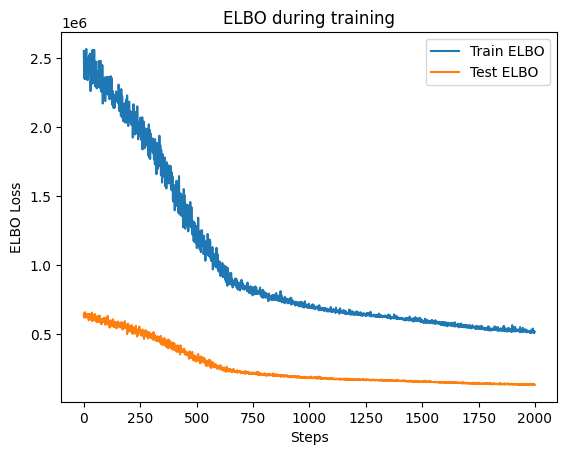

Weight learned for each feature:
Turbo                : 2.0276
Engine volume        : 0.5960
Cylinders            : 0.5591
Category_Cabriolet   : -0.7618
Category_Coupe       : -0.2343
Category_Goods wagon : 0.4744
Category_Hatchback   : 0.1333
Category_Jeep        : -1.7034
Category_Limousine   : -1.3319
Category_Microbus    : -1.4385
Category_Minivan     : -1.8255
Category_Pickup      : -1.6818
Category_Sedan       : 0.3709
Category_Universal   : -1.8741
Gear box type_Automatic : -0.7747
Gear box type_Manual : 0.5897
Gear box type_Tiptronic : -1.6290
Gear box type_Variator : -1.4691
Quality : -0.5671824
Leather interior     : 1.3409
Manufacturer_encoded : 1.6117
Category_Cabriolet   : 0.9758
Category_Coupe       : 0.1783
Category_Goods wagon : -0.6581
Category_Hatchback   : -0.2810
Category_Jeep        : 1.7691
Category_Limousine   : 1.7342
Category_Microbus    : 1.4906
Category_Minivan     : 1.7079
Category_Pickup      : 2.1354
Category_Sedan       : -0.4834
Category_Universal   : 1

In [41]:

plt.plot(train_elbos, label="Train ELBO")
plt.plot(test_elbos, label="Test ELBO")
plt.xlabel("Steps")
plt.ylabel("ELBO Loss")
plt.legend()
plt.title("ELBO during training")
plt.show()

#X.columns
latent = guide(X_train_quality, X_train_performance, X_train_status, X_train_seniority)  # sample un point dans la distribution approx
weights_quality = latent['w_quality'].detach().cpu().numpy()
weights_status = latent['w_status'].detach().cpu().numpy()
weights_seniority = latent['w_seniority'].detach().cpu().numpy()
weights_performance = latent['w_performance_x'].detach().cpu().numpy()
weights_performance_q = latent['w_performance_q'].detach().cpu().numpy()



print("Weight learned for each feature:")
for name, w in zip(columns_quality, weights_quality):
    print(f"{name:20s} : {w:.4f}")
for name, w in zip(columns_performance, weights_performance):
    print(f"{name:20s} : {w:.4f}")
print("Quality :", weights_performance_q)
for name, w in zip(columns_status, weights_status):
    print(f"{name:20s} : {w:.4f}")
for name, w in zip(columns_seniority, weights_seniority):
    print(f"{name:20s} : {w:.4f}")

# Optionnel : biais et sigma
#print(f"Biais learned : {latent['bias'].item():.4f}")
#print(f"Sigma learned : {latent['sigma'].item():.4f}")


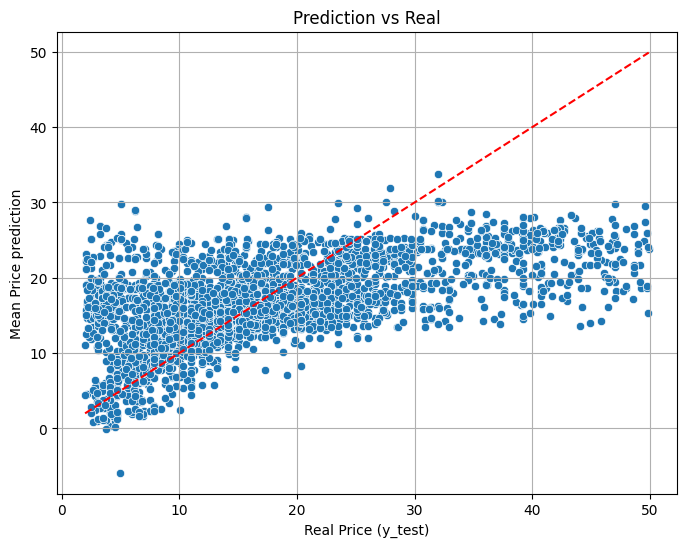

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from pyro.infer import Predictive

predictive = Predictive(model2, guide=guide, num_samples=1000)
samples = predictive(X_test_quality, X_test_performance, X_test_status, X_test_seniority)

# Moyenne des prédictions (shape: [batch_size])
y_pred_mean = samples["obs"].mean(0)      # moyenne bayésienne
y_pred_std = samples["obs"].std(0)        # incertitude prédictive

# y_test doit être de même type et forme
y_test_np = y_test.detach().numpy()
y_pred_np = y_pred_mean.detach().numpy()
y_std_np = y_pred_std.detach().numpy()

# Scatter plot : prédiction vs vrai
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_np, y=y_pred_np)
plt.plot([y_test_np.min(), y_test_np.max()], [y_test_np.min(), y_test_np.max()], 'r--')  # ligne y=x
plt.xlabel("Real Price (y_test)")
plt.ylabel("Mean Price prediction")
plt.title("Prediction vs Real")
plt.grid(True)
plt.show()


In [44]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test_np, y_pred_np)
rmse = torch.sqrt(torch.tensor(mse))
mae = mean_absolute_error(y_test_np, y_pred_np)
r2 = r2_score(y_test_np, y_pred_np)


print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R²    : {r2:.4f}")
print("Y_std:", y_std_np)
print("Y_pred:", y_pred_np)


MAE  : 6.89
RMSE : 9.22
R²    : 0.3107
Y_std: [1.7115474 1.7581495 1.5655926 ... 1.3700157 1.4709605 1.370674 ]
Y_pred: [20.453905   7.8268414 14.157797  ... 18.610554  17.949572  15.980857 ]
